In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 7)

import patsy
import statsmodels.api as sm

from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway


/var/folders/0c/8h33tfc16f3_j9jslnwvfwcc0000gn/T/ipykernel_6961/1103344680.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Loading in data

In [2]:
df = pd.read_excel('/Users/macbookpro/Documents/GitHub/Group019_WI24/data/tech_layoffs.xlsx')
df.head()

,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,3,ShareChat,Bengaluru,India,Asia,200,2023-12-20,15.0,1333,1133,Consumer,Series H,$1700,2023,12.97194,77.59369
1,4,InSightec,Haifa,Israel,Asia,100,2023-12-19,20.0,500,400,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,6,Enphase Energy,San Francisco Bay Area,USA,North America,350,2023-12-18,10.0,3500,3150,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,7,Udaan,Bengaluru,India,Asia,100,2023-12-18,10.0,1000,900,Retail,Unknown,1500,2023,12.97194,77.59369
4,14,Cruise,San Francisco Bay Area,USA,North America,900,2023-12-14,24.0,3750,2850,Transportation,Acquired,$15000,2023,37.77493,-122.41942


## Correcting data types

In order to prepare the data for exploratory analysis, we are going to correct the datatypes such that they are easily usable by plotting functions.

In [3]:
df.dtypes

#                                       int64
Company                                object
Location_HQ                            object
Country                                object
Continent                              object
Laid_Off                                int64
Date_layoffs                   datetime64[ns]
Percentage                            float64
Company_Size_before_Layoffs             int64
Company_Size_after_layoffs              int64
Industry                               object
Stage                                  object
Money_Raised_in_$_mil                  object
Year                                    int64
lat                                   float64
lng                                   float64
dtype: object

In [4]:
df['Funding'] = df['Money_Raised_in_$_mil'].apply(lambda s: np.float64(s[1:])) 
df['Funding'].head()

0     1700.0
1      733.0
2      116.0
3      500.0
4    15000.0
Name: Funding, dtype: float64

#### Company Size
Now, let's ask the following question: Does the size of the company affect the percentage of employees that the company will lay off? 

Determining if there is a relationship between the size of the company before layoffs and the percentage of employees that were laid off can be useful in understanding the factors that affect layoffs. In order to answer the question above, let's first look at the distributions for the company size before layoffs and the percentage of employees that were laid off.

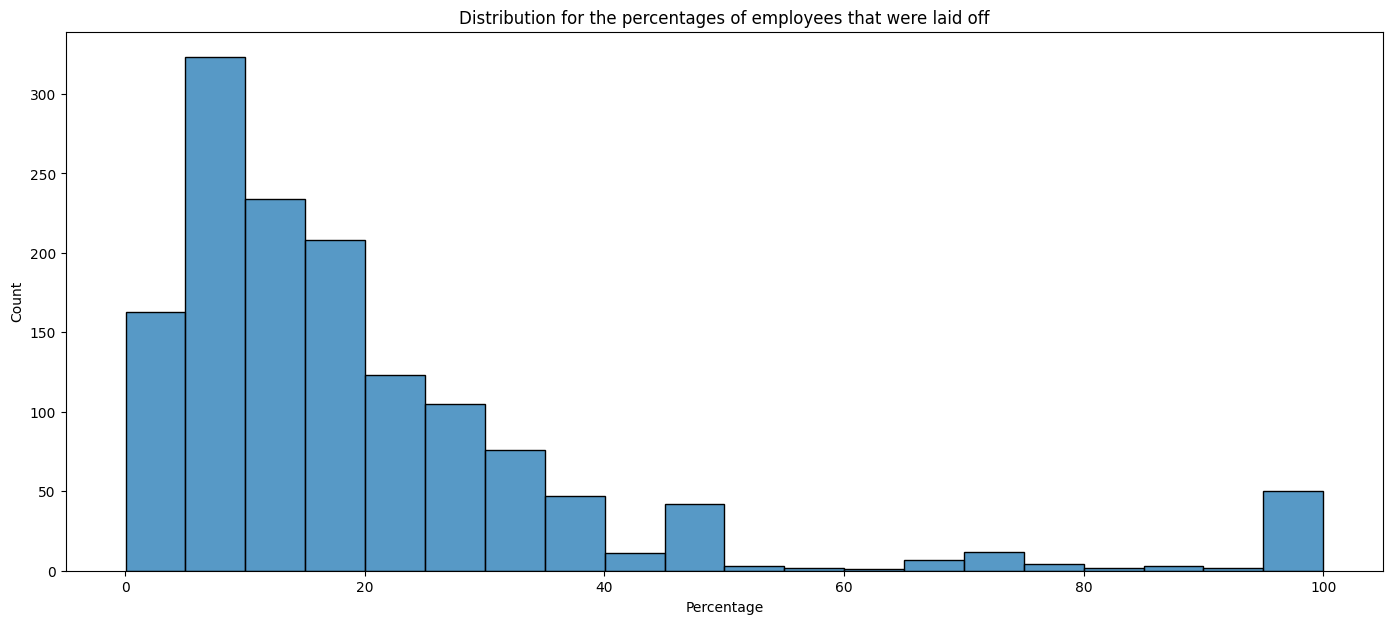

In [5]:
sns.histplot(df['Percentage'], bins=20)
plt.title('Distribution for the percentages of employees that were laid off');

In [6]:
df.sort_values(by='Percentage', ascending=False).head(10)

,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng,Funding
1417,3290,Frontdesk,Milwaukee,USA,North America,200,2024-02-01,100.0,200,0,Travel,Unknown,$26,2024,43.03890,-87.90647,26.0
1067,2629,Pocketmath,Singapore,Singapore,Asia,21,2021-01-20,100.0,21,0,Marketing,Unknown,$20,2021,1.28967,103.85007,20.0
1061,2606,Katerra,San Francisco Bay Area,USA,North America,2434,2021-06-01,100.0,2434,0,Construction,Unknown,$1600,2021,37.45383,-122.18219,1600.0
1031,2544,Ahead,San Francisco Bay Area,USA,North America,44,2022-04-14,100.0,44,0,Healthcare,Unknown,$9,2022,37.77493,-122.41942,9.0
84,323,Dealtale,Tel Aviv,Israel,Asia,70,2023-08-09,100.0,70,0,Sales,Acquired,$2,2023,32.08088,34.78057,2.0
995,2482,BeyondMinds,Tel Aviv,Israel,Asia,65,2022-05-23,100.0,65,0,Data,Series A,$16,2022,32.08088,34.78057,16.0
973,2438,Udayy,Gurugram,India,Asia,100,2022-06-01,100.0,100,0,Education,Seed,$2,2022,28.46010,77.02635,2.0
952,2390,The Grommet,Boston,USA,North America,40,2022-06-09,100.0,40,0,Retail,Acquired,$5,2022,42.35843,-71.05977,5.0
913,2333,SummerBio,San Francisco Bay Area,USA,North America,101,2022-06-20,100.0,101,0,Healthcare,Unknown,$7,2022,37.45383,-122.18219,7.0
870,2252,Crejo.Fun,Bengaluru,India,Asia,170,2022-06-30,100.0,170,0,Education,Seed,$3,2022,12.97194,77.59369,3.0


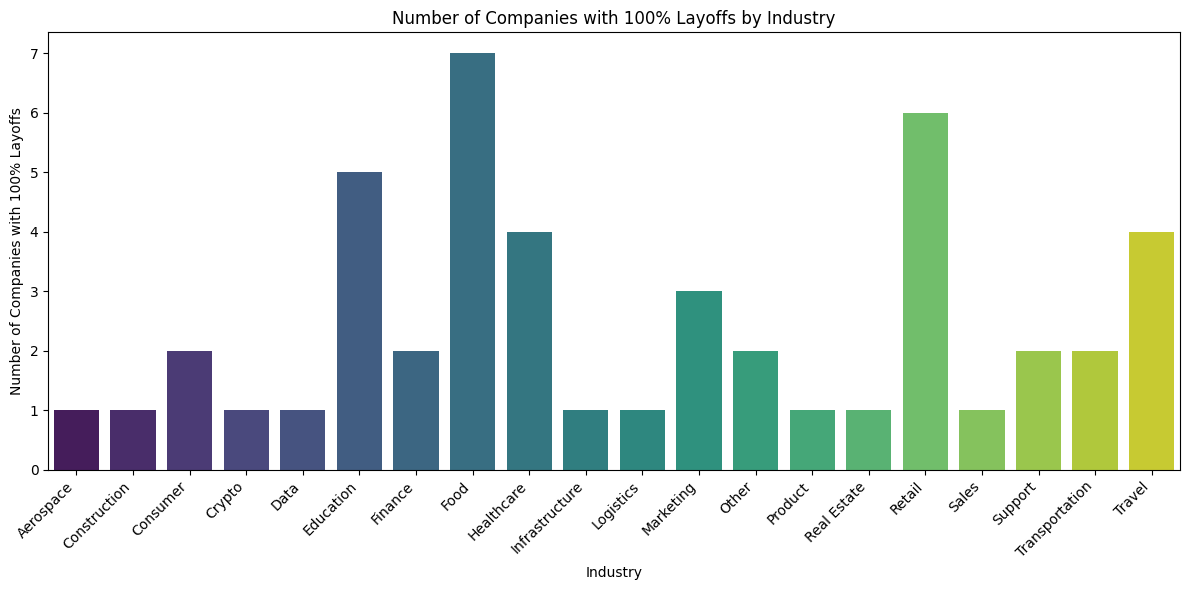

In [7]:
companies_with_100_percentage = df[df['Percentage'] == 100]

# Group the filtered DataFrame by the 'Industry' column and count the number of companies in each group
companies_count_by_industry = companies_with_100_percentage.groupby('Industry').size().reset_index(name='Count')

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(data=companies_count_by_industry, x='Industry', y='Count', hue='Industry', palette='viridis')
plt.xlabel('Industry')
plt.ylabel('Number of Companies with 100% Layoffs')
plt.title('Number of Companies with 100% Layoffs by Industry')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

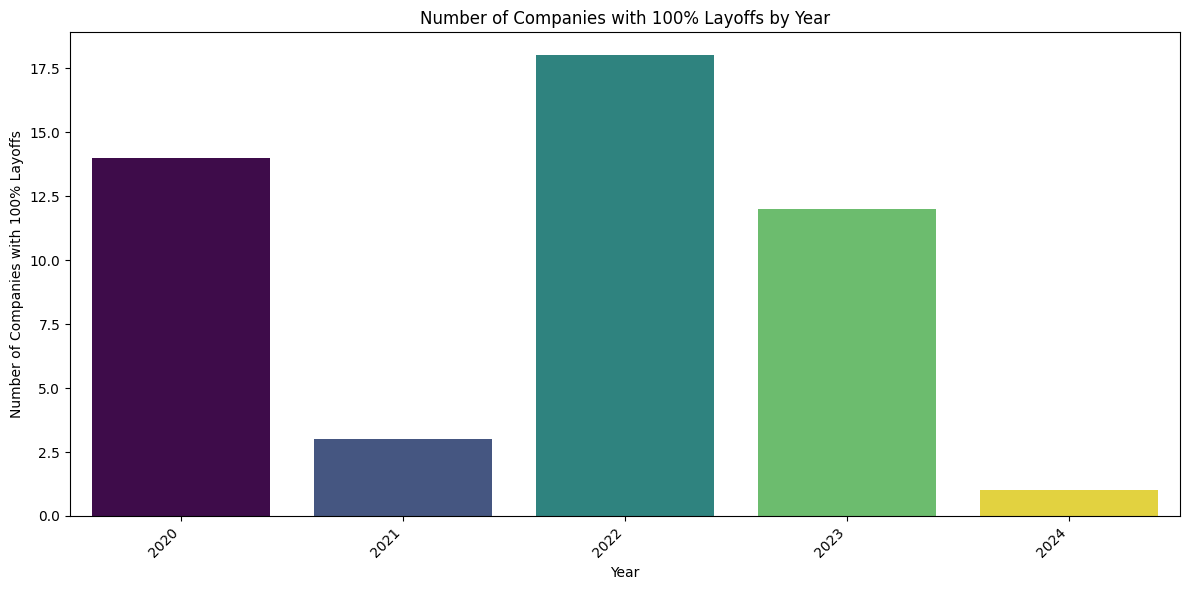

In [14]:
companies_with_100_percentage = df[df['Percentage'] == 100]

# Group the filtered DataFrame by the 'Year' column and count the number of companies in each group
companies_count_by_year = companies_with_100_percentage.groupby('Year').size().reset_index(name='Count')

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(data=companies_count_by_year, x='Year', y='Count', hue='Year', palette='viridis', legend=None)
plt.xlabel('Year')
plt.ylabel('Number of Companies with 100% Layoffs')
plt.title('Number of Companies with 100% Layoffs by Year')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [22]:
# Filter the DataFrame to include only rows where the 'Percentage' column equals 100
companies_with_100_percentage = df[df['Percentage'] == 100]

# Separate the company size for 100% layoffs for each year
company_size_by_year = [companies_with_100_percentage[companies_with_100_percentage['Year'] == year]['Company_Size_before_Layoffs'] 
                        for year in df['Year'].unique()]

# Perform ANOVA
f_statistic, p_value = f_oneway(*company_size_by_year)

# Print the ANOVA results
print("ANOVA Results:")
print("F-statistic:", f_statistic)
print("P-value:", p_value)


ANOVA Results:
F-statistic: 2.1863652452746707
P-value: 0.08654579753082588


In [19]:
companies_with_100_percentage = df[df['Percentage'] == 100]

# Separate the company size for 100% layoffs and for each year
company_size_100_percent = companies_with_100_percentage['Company_Size_before_Layoffs']
company_size_by_year = [df[df['Year'] == year]['Company_Size_before_Layoffs'] for year in df['Year'].unique()]

# Perform t-tests for each year
for year, company_size_year in zip(df['Year'].unique(), company_size_by_year):
    t_statistic, p_value = ttest_ind(company_size_100_percent, company_size_year)
    print(f"T-test Results for Year {year}:")
    print("T-statistic:", t_statistic)
    print("P-value:", p_value)
    print()

T-test Results for Year 2023:
T-statistic: -1.2001023747101556
P-value: 0.23064395075375724

T-test Results for Year 2022:
T-statistic: -0.9728564125161134
P-value: 0.3310010299059366

T-test Results for Year 2021:
T-statistic: -4.45056325719295
P-value: 3.782074114996239e-05

T-test Results for Year 2020:
T-statistic: -1.8462070327884963
P-value: 0.06564171777468955

T-test Results for Year 2024:
T-statistic: -1.90947640714304
P-value: 0.060830467825716314



In [ ]:
outcome, predictors = patsy.dmatrices('Percentage ~ Company_Size_before_Layoffs', df)
model = sm.OLS(outcome, predictors)
results = model.fit()
print(results.summary())


Based on the table above, if there were 0% employees laid off, the company size would be around 22 employees ($\beta_0$ = 22.2617). The effect size is -.0001, which means that for every 1 unit increase in company size, you expect to see a 0.0001 unit decrease in the percentage of employees laid off.

Now, let's plot the line of best fit to visualize how this relaitonship looks like.

In [ ]:
# Plotting scatterplot comparing Company_Size_before_Layoffs and Percentage laid off
sns.scatterplot(x='Company_Size_before_Layoffs', y='Percentage', data=df, s=100);

# Plotting line of best fit
sns.regplot(x='Company_Size_before_Layoffs', y='Percentage', data=df, scatter=False, color='blue')

plt.title('Company Size Before Layoffs vs. Percentage of Employees Laid Off', fontsize=16)
plt.xlabel('Company Size Before Layoffs', fontsize=14)
plt.ylabel('Percentage of Layoffs', fontsize=14)
plt.show()


Talk about the plot

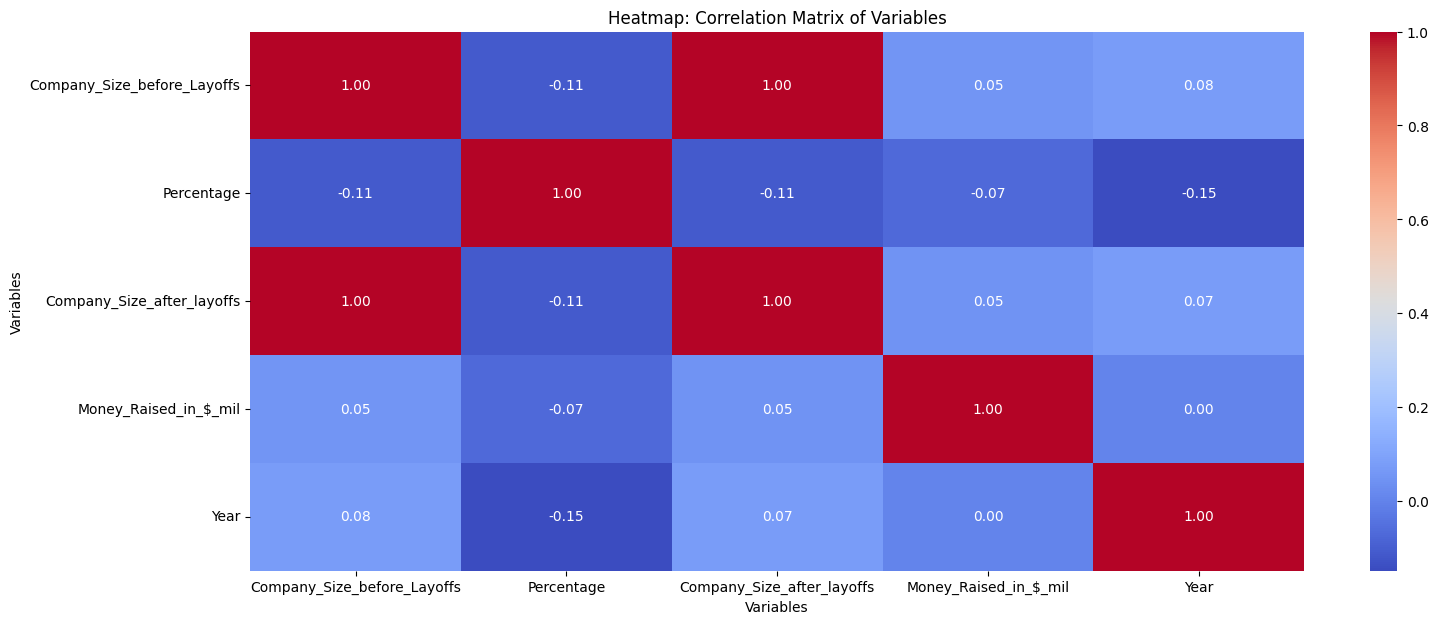

In [18]:
df['Money_Raised_in_$_mil'] = df['Money_Raised_in_$_mil'].str.replace('$', '')

heatmap_data = df[['Company_Size_before_Layoffs', 'Percentage', 'Company_Size_after_layoffs', 'Money_Raised_in_$_mil', 'Year']]

# Create the correlation matrix
correlation_matrix = heatmap_data.corr()

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Add labels and title
plt.title('Heatmap: Correlation Matrix of Variables')
plt.xlabel('Variables')
plt.ylabel('Variables')

# Show plot
plt.show()

In [17]:
#T test for company size before layoffs and percentage of layoffs
company_size_before_layoffs = df['Company_Size_before_Layoffs']
percentage = df['Percentage']

# Perform t-test
t_statistic, p_value = ttest_ind(company_size_before_layoffs, percentage)

# Print the t-test results
print("T-test Results:")
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-test Results:
T-statistic: 5.920793709581646
P-value: 3.5893485327245788e-09


In this case, since the p-value is very small (3.5893485327245788e-09), we reject the null hypothesis and conclude that there is a significant difference between the company size before layoffs and the percentage of layoffs.